### Imports & Setup

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve
)

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


### Load Data & SQL Connection

In [4]:
#Define relative path 
DATA_DIR = Path("../data")
file_path = DATA_DIR / "Telco_customer_churn.xlsx"

assert file_path.exists(), f"Dataset not found at {file_path}."

#Load dataset
df = pd.read_excel(file_path)

#Create SQLite connect
conn = sqlite3.connect(":memory:")

#save df to SQL
df.to_sql("telco",conn,index=False,if_exists="replace")

print("Database ready with table 'telco'")

Database ready with table 'telco'


### Query Featured from SQL

In [6]:
query = """
SELECT [Senior Citizen], Partner, Dependents, [Tenure Months], Contract, [Payment Method],
       [Monthly Charges], [Total Charges], [Churn Value]
FROM telco;
"""

df_sql = pd.read_sql_query(query, conn)
df_sql.head()


,Senior Citizen,Partner,Dependents,Tenure Months,Contract,Payment Method,Monthly Charges,Total Charges,Churn Value
0,No,No,No,2,Month-to-month,Mailed check,53.85,108.15,1
1,No,No,Yes,2,Month-to-month,Electronic check,70.70,151.65,1
2,No,No,Yes,8,Month-to-month,Electronic check,99.65,820.5,1
3,No,Yes,Yes,28,Month-to-month,Electronic check,104.80,3046.05,1
4,No,No,Yes,49,Month-to-month,Bank transfer (automatic),103.70,5036.3,1


### Prepare Data for ML

In [8]:
data = df_sql.copy()

#Ensure numeric conversion
data["Total Charges"] = pd.to_numeric(data["Total Charges"], errors="coerce")
data["Total Charges"] = data["Total Charges"].fillna(data["Total Charges"].median())


#Define features
categorical = ["Partner","Senior Citizen", "Dependents", "Contract", "Payment Method"]
numeric = [ "Tenure Months", "Monthly Charges", "Total Charges"]

#Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
    ]
)

print("Prepared features:", categorical + numeric)

Prepared features: ['Partner', 'Senior Citizen', 'Dependents', 'Contract', 'Payment Method', 'Tenure Months', 'Monthly Charges', 'Total Charges']


### Train/Validation/Test Split

In [10]:
#Target variable
y= data["Churn Value"]
X = data.drop("Churn Value", axis = 1)

if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X, columns=data.drop("Churn Value", axis=1).columns)

#First split: train + temp
X_train, X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.3, random_state=42,stratify=y)

#Second split: Validation + Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, 
                                                random_state=42, stratify=y_temp)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_val   = pd.DataFrame(X_val, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

Train size: 4930
Validation size: 1056
Test size: 1057


### Logistic Regression Baseline

In [12]:
#Train model
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

log_reg.fit(X_train,y_train)

#Validate
y_val_pred = log_reg.predict(X_val)
y_val_proba = log_reg.predict_proba(X_val)[:,1]

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("Validation Recall:", recall_score(y_val, y_val_pred))

Validation Accuracy: 0.7263257575757576
Validation ROC-AUC: 0.8363379050073638
Validation Recall: 0.8357142857142857


### Logistic Regression Hyperparameter Tuning

In [14]:
param_grid = {
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear"],
    "model__class_weight": [None, "balanced"]
}

grid_log = GridSearchCV(log_reg, param_grid, cv=5, scoring="recall", n_jobs=-1)
grid_log.fit(X_train, y_train)

print("Best Parameters:", grid_log.best_params_)
print("Best CV Recall:", grid_log.best_score_)


Best Parameters: {'model__C': 0.001, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best CV Recall: 0.8356409581468809


### Evaluation of Logistic Regression after hyperparameter tuning

In [16]:
best_log = grid_log.best_estimator_
y_val_pred = best_log.predict(X_val)
y_val_proba = best_log.predict_proba(X_val)[:,1]

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("Validation Recall:", recall_score(y_val, y_val_pred))


Validation Accuracy: 0.7102272727272727
Validation ROC-AUC: 0.8349249815905744
Validation Recall: 0.8678571428571429


### Gradient Boosting Baseline

In [18]:
# Train
gb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])
gb.fit(X_train, y_train)

# Validate
y_val_pred = gb.predict(X_val)
y_val_proba = gb.predict_proba(X_val)[:,1]

print("Validation Accuracy GB:", accuracy_score(y_val, y_val_pred))
print("Validation ROC-AUC GB:", roc_auc_score(y_val, y_val_proba))
print("Validation Recall GB:", recall_score(y_val, y_val_pred))

Validation Accuracy GB: 0.7888257575757576
Validation ROC-AUC GB: 0.8463342231222387
Validation Recall GB: 0.5285714285714286


### Gradient Boosting Hyperparameter Tuning

In [20]:
param_grid = {
    "model__n_estimators": [100, 300, 500],       # number of boosting stages
    "model__learning_rate": [0.01, 0.05, 0.1],    # step size
    "model__max_depth": [2, 3, 5],                # depth of trees
    "model__subsample": [0.8, 1.0],               # row sampling
    "model__min_samples_split": [2, 10, 20],      # min samples to split
    "model__min_samples_leaf": [1, 5, 10]         # min samples per leaf
}

grid_gb = GridSearchCV(
    gb, 
    param_grid, 
    cv=3, 
    scoring="recall", 
    n_jobs=-1, 
    verbose=1
)

grid_gb.fit(X_train, y_train)

print("Best Params:", grid_gb.best_params_)
print("Best CV Recall:", grid_gb.best_score_)


Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 500, 'model__subsample': 0.8}
Best CV Recall: 0.5328746177370031


### Evaluation of Gradient Boosting after Hyperparameter Tuning

In [22]:
best_gb = grid_gb.best_estimator_

y_val_pred = best_gb.predict(X_val)
y_val_proba = best_gb.predict_proba(X_val)[:,1]

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC-AUC (Best GB):", roc_auc_score(y_val, y_val_proba))
print("Validation Recall (Best GB):", recall_score(y_val, y_val_pred))

Validation Accuracy: 0.7869318181818182
Validation ROC-AUC (Best GB): 0.8436395434462445
Validation Recall (Best GB): 0.5142857142857142


### HistGradientBoosting 

In [24]:
# Define final pipeline with best params
best_hgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", HistGradientBoostingClassifier(
        l2_regularization=1.0,
        learning_rate=0.05,
        max_bins=128,
        max_depth=3,
        max_features=1.0,
        max_iter=200,
        max_leaf_nodes=15,
        min_samples_leaf=20,
        random_state=42
    ))
])

# Fit on training set
best_hgb.fit(X_train, y_train)

# Validate
y_val_pred = best_hgb.predict(X_val)
y_val_proba = best_hgb.predict_proba(X_val)[:, 1]

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("Validation Recall:", recall_score(y_val, y_val_pred))

Validation Accuracy: 0.8039772727272727
Validation ROC-AUC: 0.848129142120766
Validation Recall: 0.5714285714285714


### XGBoost Baseline

In [26]:
xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ))
])

xgb.fit(X_train, y_train)

y_val_pred = xgb.predict(X_val)
y_val_proba = xgb.predict_proba(X_val)[:, 1]

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("XGBoost Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("XGBoost Validation Recall:", recall_score(y_val, y_val_pred))


XGBoost Validation Accuracy: 0.7755681818181818
XGBoost Validation ROC-AUC: 0.8300902061855668
XGBoost Validation Recall: 0.5321428571428571


### XGBoost Hyperparameter Tuning

In [28]:
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__scale_pos_weight": [1, 2, 3]  
}


grid_xgb = GridSearchCV(
    xgb,
    param_grid,
    cv=3,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)

print("Best Params (XGB):", grid_xgb.best_params_)
print("Best CV Recall (XGB):", grid_xgb.best_score_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Params (XGB): {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__scale_pos_weight': 3, 'model__subsample': 0.8}
Best CV Recall (XGB): 0.8532110091743119


### Evaluation of XGboost After Hyperparameter Tuning

In [30]:
best_xgb = grid_xgb.best_estimator_
y_val_pred = best_xgb.predict(X_val)
y_val_proba = best_xgb.predict_proba(X_val)[:,1]

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("Validation Recall:", recall_score(y_val, y_val_pred))


Validation Accuracy: 0.7026515151515151
Validation ROC-AUC: 0.8375046023564066
Validation Recall: 0.85


### Helper Functions for Model Evaluation

In [32]:
def plot_confusion_matrices(models, X_test, y_test):
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))
    if len(models) == 1:
        axes = [axes]
    
    for ax, (name, model) in zip(axes, models.items()):
        y_pred = model.predict(X_test)
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", colorbar=False)
        ax.set_title(f"{name}\nConfusion Matrix", fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [33]:
def plot_curves(models, X_test, y_test):
    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curves")
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:,1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=name)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend()

    plt.tight_layout()
    plt.show()


### Model Evaluation on Testing Set

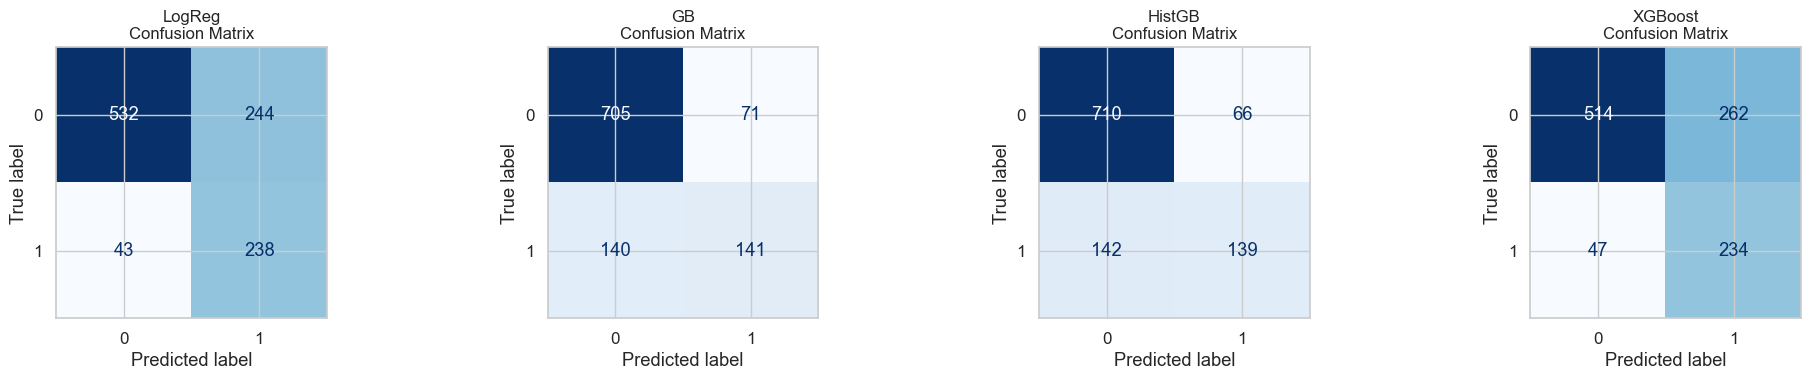

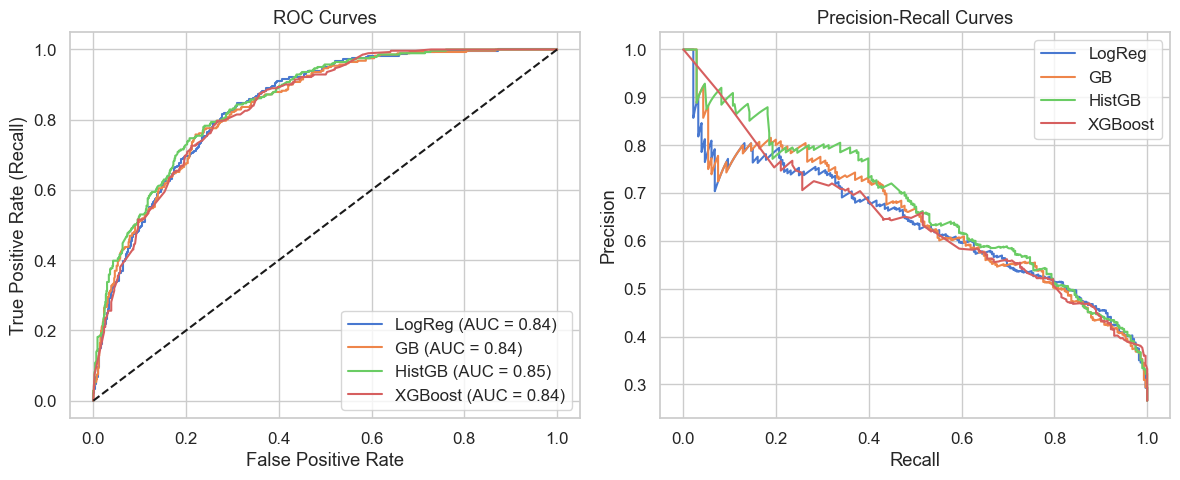

In [35]:
models = {
    "LogReg": best_log,
    "GB": best_gb,
    "HistGB": best_hgb, 
    "XGBoost": best_xgb
}

# Confusion Matrices
plot_confusion_matrices(models, X_test, y_test)

# ROC + Precision-Recall Curves
plot_curves(models, X_test, y_test)


In [36]:
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

final_results_df = pd.DataFrame(results).T
final_results_df

,Accuracy,Recall,ROC-AUC
LogReg,0.728477,0.846975,0.842458
GB,0.800378,0.501779,0.841149
HistGB,0.803217,0.494662,0.851128
XGBoost,0.707663,0.832740,0.839452


### Model Evaluation Results
We compared four models on the held-out test set using confusion matrix, ROC curves, and precision-recall curves.

1. **Logistic Regression**
   - Strength: Highest Recall (0.85),catches most churners.
   - Weakness: Lower accuracy and more false positives.
   - Use casee: When missing a churner is worse than a false alarm.
     
2. **Gradient Boosting (GB)**  
   - Strength: Balanced accuracy (0.80) between recall and ROC-AUC.  
   - Weakness: Recall drops to 0.50, missing many churners  
   - Use case: Better when we want fewer false positives.  

3. **HistGradientBoosting (HistGB)**  
   - Strength: Best ROC-AUC, most stable PR curve  
   - Weakness: Lowest recall, 0.49, meaning many churners are missed. 
   - Use case: Best at ranking customers by churn risk, but not ideal if recall is critical.  

4. **XGBoost**
  - Strength: High recall (0.83), strong industry-standard model.  
   - Weakness: Accuracy lower 0.71, more false positives 
   - Use case: Reliable choice.  

### Key Observations  
* Trade-off exists:

    - LogReg & XGBoost : best recall (catch more churners), but more false positives.

    - GB & HistGB : higher accuracy, fewer false positives, but miss many churners.

* Dataset is moderately predictive (AUC 0.84–0.85 across all).

* No major signs of overfitting (train vs test consistent).

### Recommendation

The choice depends on business priorities:

If recall is most important (don’t miss churners) : Logistic Regression or XGBoost.

If balanced performance with interpretability : Gradient Boosting.

If ranking customers by churn probability : HistGradientBoosting (highest ROC-AUC, but low recall)